<a href="https://colab.research.google.com/github/dgansen/DS-Unit-1-Sprint-2-Statistics/blob/master/module2/LS_DS_122_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [0]:
import numpy as np
from scipy import stats
import pandas as pd

In [49]:
#CONFIDENCE INTERVALS -- 1
#grab data, select NaNs
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data'
cols = ['party','handicapped-infants','water-project-cost-sharing',
        'adoption-of-the-budget-resolution','physician-fee-freeze',
        'el-salvador-aid','religious-groups-in-schools','anti-satellite-test-ban',
        'aid-to-nicaraguan-contras','mx-missile','immigration',
        'synfuels-corporation-cutback','education-spending',
        'superfund-right-to-sue','crime','duty-free-exports','export-administration-act-south-africa']
df = pd.read_csv(url,names=cols,na_values='?')
df.head()

,party,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
2,democrat,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y


In [56]:
#Make function remapping values where "yes" is one, anything else is 0
def quant_yes_vote(votes):
  votes = np.array(votes)
  ret_arr = []
  for vote in votes:
    if vote=='y':
      ret_arr.append(True)
    else:
      ret_arr.append(False)
  return ret_arr

yes_votes = df[cols[1:]].apply(quant_yes_vote)
print(yes_votes.head())
yes_votes.sum().values

   handicapped-infants  ...  export-administration-act-south-africa
0                False  ...                                    True
1                False  ...                                   False
2                False  ...                                   False
3                False  ...                                    True
4                 True  ...                                    True

[5 rows x 16 columns]


array([187, 195, 253, 177, 212, 272, 239, 242, 207, 216, 150, 171, 209,
       248, 174, 269])

In [55]:
#Numerically show a confidence interval
def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  return (mean, mean - interval, mean + interval)

mean, low, high = confidence_interval(yes_votes.sum().values)
print('Mean', mean)
print('Lower Bound',low)
print('Upper Bound',high)

Mean 213.8125
Lower Bound 194.08438405324046
Upper Bound 233.54061594675954


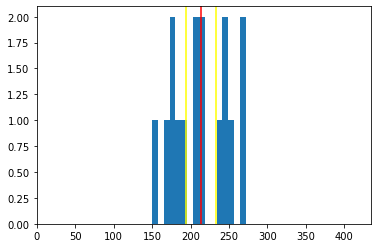

In [70]:
#CONFIDENCE INTERVAL -- 2
#Graphically show a confidence interval
import matplotlib.pyplot as plt

yeas = yes_votes.sum().values
plt.hist(yeas, bins=16)
plt.axvline(mean,color='red')
plt.axvline(low,color='yellow')
plt.axvline(high,color='yellow')
plt.xlim(0,435)
plt.show()

In [0]:
#CONFIDENCE INTERVAL -- 3
#Interpretation

Since the values presented to the analysis were a tally of yes votes given to each presented bill in the House of Representatives, the interval provides a range of expected yes's another bill in the House might get in 1984. This is based on a sample size of only 16, so the range is quite wide.

This could be used as a rough estimate, when applied to other years and compared to the margin needed for majority, to how willing the House is to pass something over time. If the range is completely above the votes needed, it could be said that the House is taking action, or that it is prone to stalemate if the range is completely below the line

In [90]:
#CHI SQUARE TEST
#import data
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/trains/trains-transformed.data'
cols = ['Number_of_cars','Number_of_different_loads',
        'CAR2_num_wheels','CAR2_length','CAR2_shape',
        'CAR2_num_loads','CAR2_load_shape',
        'CAR3_num_wheels','CAR3_length','CAR3_shape',
        'CAR3_num_loads','CAR3_load_shape',
        'CAR4_num_wheels','CAR4_length','CAR4_shape',
        'CAR4_num_loads','CAR4_load_shape',
        'CAR5_num_wheels','CAR5_length','CAR5_shape',
        'CAR5_num_loads','CAR5_load_shape','Rectangle_next_to_rectangle',
        'Rectangle_next_to_triangle','Rectangle_next_to_hexagon',
        'Rectangle_next_to_circle','Triangle_next_to_triangle',
        'Triangle_next_to_hexagon','Triangle_next_to_circle',
        'Hexagon_next_to_hexagon','Hexagon_next_to_circle',
        'Circle_next_to_circle','dir']
        
df = pd.read_csv(url,names=cols,delim_whitespace=True)
df.head()

,Number_of_cars,Number_of_different_loads,CAR2_num_wheels,CAR2_length,CAR2_shape,CAR2_num_loads,CAR2_load_shape,CAR3_num_wheels,CAR3_length,CAR3_shape,CAR3_num_loads,CAR3_load_shape,CAR4_num_wheels,CAR4_length,CAR4_shape,CAR4_num_loads,CAR4_load_shape,CAR5_num_wheels,CAR5_length,CAR5_shape,CAR5_num_loads,CAR5_load_shape,Rectangle_next_to_rectangle,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle,dir
0,5,4,2,long,openrect,3,rectanglod,2,short,slopetop,1,trianglod,3,long,openrect,1,hexagonlod,2,short,openrect,1,circlelod,0,1,0,0,0,1,0,0,1,0,east
1,4,3,2,short,ushaped,1,trianglod,2,short,opentrap,1,rectanglod,2,short,closedrect,2,circlelod,-,-,-,-,-,0,1,0,1,0,0,0,0,0,0,east
2,4,2,2,short,openrect,1,circlelod,2,short,hexagon,1,trianglod,3,long,closedrect,1,trianglod,-,-,-,-,-,0,0,0,0,1,0,1,0,0,0,east
3,5,2,2,short,opentrap,1,trianglod,2,short,dblopnrect,1,trianglod,2,short,ellipse,1,rectanglod,2,short,openrect,1,rectanglod,1,1,0,0,1,0,0,0,0,0,east
4,4,3,2,short,dblopnrect,1,trianglod,3,long,closedrect,1,rectanglod,2,short,closedrect,1,circlelod,-,-,-,-,-,0,1,0,1,0,0,0,0,0,0,east


Pick 2 Categorical Variables and run $\chi^2$ test by hand

In [101]:
#Grab observed data
observed = pd.crosstab(df['dir'],df['Number_of_different_loads'], margins=True)
observed

Number_of_different_loads,1,2,3,4,All
dir,,,,,
east,0,2,2,1,5
west,1,4,0,0,5
All,1,6,2,1,10


In [144]:
#Grab totals
N = observed['All']['All']
row_total = observed['All'][0:2].values
col_total = observed.iloc[2,:4].values

#Trim margins
just_observed = np.array(observed.iloc[:-1,:-1])
#Return array will be summed to provide chi2 score
ret_arr = []
#Expected array will be used for Scipy equation further below
exp_arr = np.empty([2,4])
for i, ob_row in enumerate(just_observed):
  for j, ob_val in enumerate(ob_row):
    #Calculate expected (from formula)
    expected = row_total[i] * col_total[j] / N
    exp_arr[i,j] = expected
    #Apply Chi2 individual equation
    retval = (ob_val - expected)**2 / expected
    ret_arr.append(retval)

chi2 = sum(ret_arr)
chi2

4.666666666666666

In [146]:
#Use Scipy to find chi2 score
chi2, p_value, dof, expected = stats.chi2_contingency(observed)

print("chi2 statistic", chi2)
print("p value", p_value)
print("degrees of freedom",dof)
print("expected frequencies table", expected)

chi2 statistic 4.666666666666666
p value 0.7925363299535328
degrees of freedom 8
expected frequencies table [[ 0.5  3.   1.   0.5  5. ]
 [ 0.5  3.   1.   0.5  5. ]
 [ 1.   6.   2.   1.  10. ]]


Null hypothesis: There is no relationship between the number of different loads on a train and the direction it was traveling in the given dataset.

Alternative hypothesis: (p<0.05) There is a statistical relation between the given variables, as evidenced by a high $\chi^2$ score and corresponding low p-value

**Result**
We cannot reject the null hypothesis, as indicated by the high p-value

## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)